<a href="https://colab.research.google.com/github/Butanium/coinrun-patchs/blob/main/coinrun_interp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting up the environment (run once)
You just have to run this when you connect to a new environment

In [1]:
# Installing package to run coinrun (fix segfaults https://github.com/googlecolab/colabtools/issues/106)
import os
del os.environ['LD_PRELOAD']

In [2]:
%%capture
!apt-get remove libtcmalloc*
!apt-get update
!apt-get install mpich build-essential qt5-default pkg-config

In [3]:
# Download modified coinrun and model 
%%capture
!git clone --recursive https://github.com/jbkjr/objective-robustness-failures
%cd objective-robustness-failures/train-procgen-pytorch/ 
!mkdir model_data
!wget https://github.com/Butanium/coinrun-patchs/blob/main/data/coinrun.pth?raw=true -O model_data/coinrun.pth

In [158]:
%%capture
%pip install ipyplot pillow 

!pip install gym3
%cd ../procgenAISC
!python setup.py install
%cd procgen
import os, sys
sys.path.append(os.getcwd())
%cd ../../train-procgen-pytorch

# ⚠️ Restart the environment (CTRL + M .) in order to have your path updated
After that you can run the cell below

In [160]:
%cd objective-robustness-failures/train-procgen-pytorch/

[Errno 2] No such file or directory: 'objective-robustness-failures/train-procgen-pytorch/'
/content/objective-robustness-failures/train-procgen-pytorch
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
ERROR: ld.so: object '/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4' from LD_PRELOAD cannot be preloaded (cannot open shared object file): ignored.
agents/             hyperparams/  model_data/           render.py
common/             __init__.py   plot_training_csv.py  test.py
compute_metrics.py  logs/         Readme.md             train.py


# Sanity check
You should be able to import the procgen module

In [2]:
import procgen

# Imports

In [161]:
from common.env.procgen_wrappers import *
from common.logger import Logger
from common.storage import Storage
from common.model import NatureModel, ImpalaModel
from common.policy import CategoricalPolicy
from common import set_global_seeds, set_global_log_levels

import os, time, yaml, argparse
import gym
from procgen import ProcgenEnv
import random
import torch
import json
import numpy as np

# Environment code

## Simulation init

In [40]:
def load_env_and_agent(exp_name,
                       num_envs,
                       model_file,
                       start_level,
                       num_levels,
                       distribution_mode="hard",
                       param_name="hard",
                       device="cpu",
                       gpu_device=0,
                       random_percent=0,
                       logdir=None,
                       num_threads=10):

    env_name = "coinrun"

    ####################
    ## HYPERPARAMETERS #
    ####################
    with open('hyperparams/procgen/config.yml', 'r') as f:
        hyperparameters = yaml.safe_load(f)[param_name]

    ############
    ## DEVICE ##
    ############
    if device == 'gpu':
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_device)
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    #################
    ## ENVIRONMENT ##
    #################
    def create_venv(hyperparameters):
        venv = ProcgenEnv(num_envs=num_envs,
                        env_name=env_name,
                        num_levels=num_levels,
                        start_level=int(start_level),
                        distribution_mode=distribution_mode,
                        num_threads=num_threads,
                        random_percent=random_percent)
        venv = VecExtractDictObs(venv, "rgb")
        normalize_rew = hyperparameters.get('normalize_rew', True)
        if normalize_rew:
            venv = VecNormalize(venv, ob=False) # normalizing returns, but not
            #the img frames
        venv = TransposeFrame(venv)
        venv = ScaledFloatFrame(venv)
        return venv
    n_steps = hyperparameters.get('n_steps', 256)

    env = create_venv(hyperparameters)

    ############
    ## LOGGER ##
    ############
    logger = Logger(num_envs, "./logs")

    ###########
    ## MODEL ##
    ###########
    observation_space = env.observation_space
    observation_shape = observation_space.shape
    architecture = hyperparameters.get('architecture', 'impala')
    in_channels = observation_shape[0]
    action_space = env.action_space

    # Model architecture
    if architecture == 'nature':
        model = NatureModel(in_channels=in_channels)
    elif architecture == 'impala':
        model = ImpalaModel(in_channels=in_channels)

    # Discrete action space
    recurrent = hyperparameters.get('recurrent', False)
    if isinstance(action_space, gym.spaces.Discrete):
        action_size = action_space.n
        policy = CategoricalPolicy(model, recurrent, action_size)
    else:
        raise NotImplementedError
    policy.to(device)

    #############
    ## STORAGE ##
    #############
    hidden_state_dim = model.output_dim
    storage = Storage(observation_shape, hidden_state_dim, n_steps, num_envs, device)

    ###########
    ## AGENT ##
    ###########
    algo = hyperparameters.get('algo', 'ppo')
    if algo == 'ppo':
        from agents.ppo import PPO as AGENT
    else:
        raise NotImplementedError
    agent = AGENT(env, policy, logger, storage, device, 0, **hyperparameters)

    agent.policy.load_state_dict(torch.load(model_file, map_location=device)["model_state_dict"])
    agent.n_envs = num_envs
    return agent

In [30]:
def load_episode(exp_name, level_seed, model_file, **kwargs):
    """Load a single coinrun level with fixed seed. Same level layout after reset
    logdir is just for agent logs."""
    return load_env_and_agent(
        exp_name=exp_name,
        num_envs=1,
        model_file=model_file,
        num_levels=1,
        start_level=level_seed,
        num_threads=1, **kwargs
       )

## Run the agent

In [88]:
def run_env(
    exp_name,
    model_file,
    level_seed,
    hook = None,
    logfile=None,
    reset_mode="off", 
    max_num_timesteps=10_000,
    save_value=False,
    **kwargs):
    """
    Runs one coinrun level.
    Reset modes:
        - inv_coin returns when agent gets the inv coin OR finishes the level
        - complete returns when the agent finishes the level
        - off resets only when max_num_timesteps is reached (repeating always the same level)
    
    returns level metrics. If logfile (csv) is supplied, metrics are also
    appended there.
    """
    if save_value:
        raise NotImplementedError

    if logfile is not None:
        append_to_csv = True

    agent = load_episode(exp_name, level_seed, model_file, **kwargs)
    
    obs = agent.env.reset()
    hidden_state = np.zeros((agent.n_envs, agent.storage.hidden_state_size))
    done = np.zeros(agent.n_envs)


    def log_to_csv(metrics):
        """write metrics to csv"""
        if not metrics:
            return
        column_names = ["seed", "steps", "rand_coin", "coin_collected", "inv_coin_collected", "died", "timed_out"]
        metrics = [int(m) for m in metrics]
        if append_to_csv:
            with open(logfile, "a") as f:
                w = csv.writer(f)
                if f.tell() == 0: # write header first
                    w.writerow(column_names)
                w.writerow(metrics)


    def log_metrics(done: bool, info: dict):
        """
        When run complete, log metrics in the 
        following format:
        seed, steps, randomize_goal, collected_coin, collected_inv_coin, died, timed_out
        """
        metrics = None
        if done:
            keys = ["prev_level_seed", "prev_level/total_steps", "prev_level/randomize_goal", "prev_level_complete", "prev_level/invisible_coin_collected"]
            metrics = [info[key] for key in keys]
            if info["prev_level_complete"]:
                metrics.extend([False, False])
            else:
                timed_out = info["prev_level/total_steps"] > 999
                metrics.extend([not timed_out, timed_out])
        elif info["invisible_coin_collected"]:
            keys = ["level_seed", "total_steps", "randomize_goal"]
            metrics = [info[key] for key in keys]
            metrics.extend([-1, True, -1, -1])
        else:
            raise
        log_to_csv(metrics)
        return metrics


    def check_if_break(done: bool, info: dict):
        if reset_mode == "inv_coin":
            return done or info["invisible_coin_collected"]
        elif reset_mode == "complete":
            return done
        elif reset_mode == "off":
            return False
        else:
            raise ValueError("Reset mode must be one of inv_coin, complete, off."
                             f"Instead got {reset_mode}")

    step = 0
    if hook is None:
      hook = lambda obs, *args : obs
    while step < max_num_timesteps:
        agent.policy.eval()
        for _ in range(agent.n_steps):  # = 256
            step += 1
            act, log_prob_act, value, next_hidden_state = agent.predict(obs, hidden_state, done)
            next_obs, rew, done, info = agent.env.step(act)

            agent.storage.store(obs, hidden_state, act, rew, done, info, log_prob_act, value)
            hooked_obs = hook(next_obs, agent)
            if hooked_obs.shape != obs.shape:
              raise Exception("your hook changes the obs shape")
            obs : np.ndarray = hooked_obs
            hidden_state = next_hidden_state

            if check_if_break(done[0], info[0]):
                log_metrics(done[0], info[0])
                return
    return


## Utils

In [157]:
import matplotlib.pyplot as plt
import ipyplot
from PIL import Image
import stackview
import pyclesperanto_prototype as cle
# Activate widgets in google colab
from google.colab import output
output.enable_custom_widget_manager()

In [120]:
img = np.uint8(np.einsum('cwh -> whc', hook.saves[0][0])* 255)
im2 = Image.fromarray(img).convert("L")

[[161 161 160 ...  26  18  20]
 [147 147 161 ...  39  16  21]
 [153 153 161 ...  32  26  15]
 ...
 [153 153 161 ... 161 161 153]
 [161 147 147 ... 147 147 147]
 [147 147 153 ... 153 161 153]]


In [163]:
def plot_images(img_arrays, max_images=20, img_width=150):
  ipyplot.plot_images(img_arrays, max_images=max_images, img_width=img_width)

# Experiment

In [168]:
class ObsHook:
  def __init__(self, saveRate : int):
    self.saveRate = saveRate
    self.current = 0
    self.saves = []
    self.agent = None
  
  def __call__(self, obs : np.ndarray, agent) -> np.ndarray:
      if self.agent is None:
        self.agent = agent
      self.current += 1
      if self.current >= self.saveRate:
        self.current = 0
        self.saves.append(obs)
      return obs

  def end(self):
    print(self.saves[0].shape)
    plotable = list(map(lambda obs :(np.uint8(np.einsum('cwh -> whc', obs[0])* 255)), self.saves))
    self.plotable = np.array(plotable)
    plot_images(self.plotable)



(1, 3, 64, 64)


/usr/local/lib/python3.8/dist-packages/ipyplot/_img_helpers.py:78: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if image.dtype in [np.float, np.float32, np.float64]:



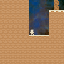
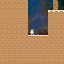
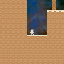
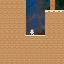
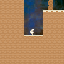
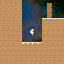
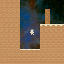
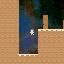
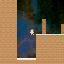
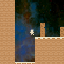
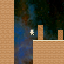
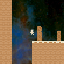
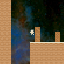
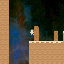
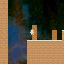
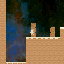
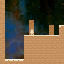
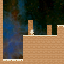
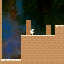
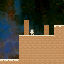


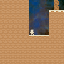
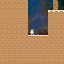
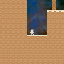
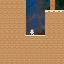
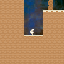
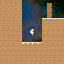
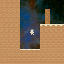
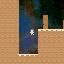
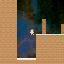
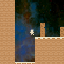
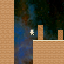
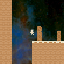
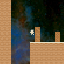
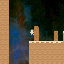
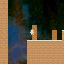
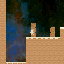
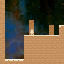
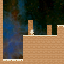
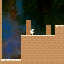
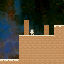

In [169]:
hook = ObsHook(1)
run_env("test experiment", "model_data/coinrun.pth", 0xc0ffee, hook=hook, max_num_timesteps=100)
hook.end()